# MoodWave: Voice-Driven Emotion Detection

## Business Understanding

When working as a customer service agent, you are bound to run into the whole spectrum of emotions - annoyance, gratefulness, anger, or complete neutrality. These agents are often monitored, scored on how well - and how many issues they address. 

A satisfied customer - either leaving a positive review, or having the call recorded and review - will leave a good impression on the agent. 
A frustrated customer is more likely to leave a negative review, or a manager reviews a call that went poorly - it reflects negatively on the agent. 

Implementing AI into the customer support pipeline can be beneficial in many ways:

- If an agent knows as soon as their customer is upset, they can adjust how they speak to them, or you can even adapt the script the agent uses as the customer’s emotions fluctuate. 
- The agent feels more secure in their responses, or know that they can escalate to someone better equipped to handle difficult customers. 
- The customer feels heard, finds a resolution faster, and has an overall better experience!

#### Objective: Create a model to identify customer emotion (Upset/Not Upset) over the phone.

## Data Understanding

In this project, we are dealing with four datasets containing English audio recordings in the .wav format. Each audio recording is labeled with an emotion that the speaker is evoking in their statement. Our goal is to build a model that can successfully map an emotion to a given voice clip of someone speaking.

> Compiled datsets can be found on [Kaggle](https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en).

To achieve this, we will extract various features from the audio recordings that are relevant for analyzing speech and emotion. Here are the features we will be working with and their significance for working with audio:

1. **Mel-frequency Cepstral Coefficients (MFCCs):** MFCCs are a compact representation of the short-term power spectrum of a sound. They are widely used in speech recognition and audio analysis tasks because they capture the essential characteristics of the audio signal while being robust to noise and other variabilities. MFCCs are particularly useful for identifying the phonetic content of speech, which can be helpful in determining the emotional state of the speaker.

2. **Spectral Centroid:** The spectral centroid is a measure of the brightness or sharpness of a sound. It represents the weighted mean frequency of the spectrum and can be used to distinguish between different types of sounds or emotions. For example, a bright, harsh sound might have a higher spectral centroid than a mellow, soft sound.

3. **Chroma Features:** Chroma features describe the distribution of energy across different pitch classes (notes) in the audio signal. They are useful for capturing tonal information, which can be relevant for identifying emotions in speech, particularly those related to intonation patterns and stress.

4. **Zero-Crossing Rate:** The zero-crossing rate is a measure of the number of times the audio signal crosses the zero amplitude axis within a given time frame. It can be used to distinguish between different types of sounds, such as voiced and unvoiced speech, and can provide insights into the energy distribution of the audio signal.
RMS Energy: The Root Mean Square (RMS) energy is a measure of the overall energy or loudness of an audio signal. It can be useful for detecting variations in volume or intensity, which can be indicative of certain emotions, such as anger or excitement.

---

By extracting and analyzing these features, we can capture various acoustic characteristics of the speech signal that may be relevant for distinguishing between different emotions. This multi-faceted approach can provide a more comprehensive representation of the audio data, potentially leading to better performance in the emotion classification task.

## Data Preperation

First, we will combine our 4 datasets in English: Crema, Ravdess, Savee and Tess. Each of them contains audio in .wav format with some main labels. (Note - not all datasets represent the same emotions, we will clean up the data labels to be as generic / inclusive as possible.

We will pull each dataset into their own dataframe, making note of *where* the file is, so we can later pull our features from each audio file. 

Then, we will merge them all into one dataframe and extract our audio features as mentioned earlier:

- Mel-frequency cepstral coefficients (MFCCs)
- Spectral centroid
- Chroma features
- Zero-crossing rate

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import warnings
import zipfile
import librosa
import random
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.utils import class_weight
from scipy.stats import skew, kurtosis
from collections import Counter


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# data is zipped, and stored in folders for which dataset they came from:

# Define the path to the zipped dataset
zip_file_path = 'dataset.zip'
extracted_folder_path = 'dataset'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Crema
# Ravdess
# Savee
# Tess

In [3]:
# Define the path to the Crema folder
crema_folder_path = os.path.join(extracted_folder_path, 'Crema')

# Verify that we can access the files and extract emotion labels
data = []

# Loop through each file in the Crema folder
for file_name in os.listdir(crema_folder_path):
    if file_name.endswith('.wav'):
        # Extract the emotion label from the filename
        parts = file_name.split('_')
        emotion_code = parts[2]
        
        # Map the emotion code to the actual emotion label
        emotion_map = {
            'SAD': 'sadness',
            'ANG': 'angry',
            'DIS': 'disgust',
            'FEA': 'fear',
            'HAP': 'happy',
            'NEU': 'neutral'
        }
        emotion_label = emotion_map.get(emotion_code, 'unknown')
        
        # Store the data with the directory path minus the filename
        data.append({'filename': file_name, 'emotion': emotion_label, 'path': crema_folder_path})

# Convert the data into a DataFrame for easy access
df_crema = pd.DataFrame(data)

# Display the first few rows to verify
print(df_crema.head())

              filename  emotion           path
0  1001_DFA_ANG_XX.wav    angry  dataset\Crema
1  1001_DFA_DIS_XX.wav  disgust  dataset\Crema
2  1001_DFA_FEA_XX.wav     fear  dataset\Crema
3  1001_DFA_HAP_XX.wav    happy  dataset\Crema
4  1001_DFA_NEU_XX.wav  neutral  dataset\Crema


In [4]:
# Define the path to the Tess folder
tess_folder_path = os.path.join(extracted_folder_path, 'Tess')

# Prepare to store the data
data = []

# Loop through each emotion folder in the Tess directory
for emotion_folder in os.listdir(tess_folder_path):
    # Get the full path to the emotion folder
    emotion_folder_path = os.path.join(tess_folder_path, emotion_folder)
    
    # Extract the emotion from the folder name (e.g., "OAF_angry" -> "angry")
    emotion_label = emotion_folder.split('_')[1]
    
    # Loop through each file in the emotion folder
    for file_name in os.listdir(emotion_folder_path):
        if file_name.endswith('.wav'):
            # Store the data with the directory path minus the filename
            data.append({
                'filename': file_name, 
                'emotion': emotion_label, 
                'path': emotion_folder_path
            })

# Convert the data into a DataFrame for easy access
df_tess = pd.DataFrame(data)

# Display the first few rows to verify
print(df_tess.head())

             filename emotion                    path
0  OAF_back_angry.wav   angry  dataset\Tess\OAF_angry
1   OAF_bar_angry.wav   angry  dataset\Tess\OAF_angry
2  OAF_base_angry.wav   angry  dataset\Tess\OAF_angry
3  OAF_bath_angry.wav   angry  dataset\Tess\OAF_angry
4  OAF_bean_angry.wav   angry  dataset\Tess\OAF_angry


In [5]:
# Define the path to the Savee folder
savee_folder_path = os.path.join(extracted_folder_path, 'Savee')

# Prepare to store the data
data = []

# Define the emotion mapping based on the prefixes
emotion_map = {
    'a': 'anger',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happiness',
    'n': 'neutral',
    'sa': 'sadness',
    'su': 'surprise'
}

# Loop through each file in the Savee folder
for file_name in os.listdir(savee_folder_path):
    if file_name.endswith('.wav'):
        # Extract the prefix from the filename to determine the emotion
        prefix = file_name.split('_')[1][:2]
        
        # Map the prefix to the corresponding emotion
        emotion_label = emotion_map.get(prefix, 'unknown')
        
        # Store the data with the directory path minus the filename
        data.append({
            'filename': file_name, 
            'emotion': emotion_label, 
            'path': savee_folder_path
        })

# Convert the data into a DataFrame for easy access
df_savee = pd.DataFrame(data)

# Display the first few rows to verify
print(df_savee.head())

     filename  emotion           path
0  DC_a01.wav  unknown  dataset\Savee
1  DC_a02.wav  unknown  dataset\Savee
2  DC_a03.wav  unknown  dataset\Savee
3  DC_a04.wav  unknown  dataset\Savee
4  DC_a05.wav  unknown  dataset\Savee


In [6]:
# Define the path to the Ravdess folder
ravdess_folder_path = os.path.join(extracted_folder_path, 'Ravdess', 'audio_speech_actors_01-24')

# Prepare to store the data
data = []

# Define the emotion mapping based on the third component in the filename
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Loop through each actor's folder in the Ravdess directory
for actor_folder in os.listdir(ravdess_folder_path):
    actor_folder_path = os.path.join(ravdess_folder_path, actor_folder)
    
    # Loop through each file in the actor's folder
    for file_name in os.listdir(actor_folder_path):
        if file_name.endswith('.wav'):
            # Extract the third component from the filename to determine the emotion
            emotion_code = file_name.split('-')[2]
            
            # Map the emotion code to the corresponding emotion label
            emotion_label = emotion_map.get(emotion_code, 'unknown')
            
            # Store the data with the directory path minus the filename
            data.append({
                'filename': file_name, 
                'emotion': emotion_label, 
                'path': actor_folder_path
            })

# Convert the data into a DataFrame for easy access
df_ravdess = pd.DataFrame(data)

# Display the first few rows to verify
print(df_ravdess.head())

                   filename  emotion  \
0  03-01-01-01-01-01-01.wav  neutral   
1  03-01-01-01-01-02-01.wav  neutral   
2  03-01-01-01-02-01-01.wav  neutral   
3  03-01-01-01-02-02-01.wav  neutral   
4  03-01-02-01-01-01-01.wav     calm   

                                                path  
0  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
1  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
2  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
3  dataset\Ravdess\audio_speech_actors_01-24\Acto...  
4  dataset\Ravdess\audio_speech_actors_01-24\Acto...  


### Combining datasets 

We will merge the datsets into one dataframe, and assign unique identifiers
- Concatenate the DataFrames for each dataset.
- Assign a unique ID to each entry based on the dataset.

In [7]:
# Add a unique ID column to each dataset
df_crema['id'] = ['c_{:04d}'.format(i + 1) for i in range(len(df_crema))]
df_tess['id'] = ['t_{:04d}'.format(i + 1) for i in range(len(df_tess))]
df_savee['id'] = ['s_{:04d}'.format(i + 1) for i in range(len(df_savee))]
df_ravdess['id'] = ['r_{:04d}'.format(i + 1) for i in range(len(df_ravdess))]

# Merge the datasets into a single DataFrame
merged_data = pd.concat([df_crema, df_tess, df_savee, df_ravdess], ignore_index=True)

# Reorder columns to have 'id' as the first column
merged_data = merged_data[['id', 'filename', 'emotion', 'path']]

# Display the first few rows of the combined DataFrame
print(merged_data.head())

       id             filename  emotion           path
0  c_0001  1001_DFA_ANG_XX.wav    angry  dataset\Crema
1  c_0002  1001_DFA_DIS_XX.wav  disgust  dataset\Crema
2  c_0003  1001_DFA_FEA_XX.wav     fear  dataset\Crema
3  c_0004  1001_DFA_HAP_XX.wav    happy  dataset\Crema
4  c_0005  1001_DFA_NEU_XX.wav  neutral  dataset\Crema


In [8]:
# remember, we need at least 1000 rows to meet our requirements. 
print(f"Total rows in dataset: {merged_data.shape[0]}")

Total rows in dataset: 12162


### Extracting Features

Again, these are the features we will extract:

- **Mel-frequency cepstral coefficients (MFCCs):** Represents the short-term power spectrum of sound, commonly used in speech and audio processing to capture the timbral texture of audio.
- **Spectral centroid:** Indicates the "center of mass" of the spectrum and is often associated with the perceived brightness of a sound.
- **Chroma features:** Represents the 12 different pitch classes and captures harmonic and melodic characteristics of music / voice.
- **Zero-crossing rate:** Measures the rate at which the signal changes sign, giving insight into the noisiness or percussiveness of the sound.
- **RMS energy:** Reflects the root mean square of the audio signal and indicates the energy or loudness of the sound.
- **Pitch:** Refers to the perceived frequency of a sound, determining how high or low a sound is.

We will be using the `librosa` package to process these audio features. [Here](https://librosa.org/doc/latest/index.html) is a link to the librosa documentation.

**Note**: adding suppression for *UserWarning: Trying to estimate tuning from empty frequency set*. This is likely do to either:* **silence / low energy** (too quiet to perform reliable pitch estimation), or the file had **too short of a duration**. This warning shows up even when setting the pitch to 0 in this case.


In [9]:
def extract_features_time_series(file_path, sr=22050, n_mfcc=13, hop_length=512, n_fft=2048, duration=None, max_pad_len=862):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=sr, duration=duration)

        # Ensure consistent audio length by padding or truncating
        if duration is not None:
            max_samples = int(sr * duration)
            if len(y) < max_samples:
                y = np.pad(y, (0, max_samples - len(y)), mode='constant')
            else:
                y = y[:max_samples]

        # Extract features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)

        # Stack features along the feature axis
        features = np.vstack([mfccs, chroma, spectral_centroid, zero_crossing_rate])

        # Transpose to get shape (time_steps, features)
        features = features.T

        # Pad to ensure consistent time dimension (if needed)
        if features.shape[0] < max_pad_len:
            pad_width = max_pad_len - features.shape[0]
            features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
        else:
            features = features[:max_pad_len, :]

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None  # Return None explicitly if there's an error

In [10]:
# testing our extract_features function:
first_row = merged_data.iloc[0]
file_path = os.path.join(first_row['path'], first_row['filename'])

# Extract features directly from the file path
features = extract_features_time_series(file_path, sr=16000, n_mfcc=20, duration=3.0)
print(features.shape)  # The shape should be [time_frames, features]

(862, 34)


Old Approach (Feature Aggregation):
In the old approach, you were extracting summary statistics (mean, std, skewness, kurtosis) of features like MFCCs, spectral centroid, etc.
This method is useful when you want to transform time-series data into a set of static features, which can then be used with traditional machine learning models like Random Forests, SVMs, or Feedforward Neural Networks.
However, it loses temporal information. You're summarizing the entire time-series into a handful of values, so models that could learn sequence dependencies (like RNNs, LSTMs, GRUs, or CNNs) wouldn't be able to take full advantage of the temporal structure of the data.

#### New Time-Series Approach:
Preserving the Time-Series Structure: Instead of reducing the time-series to summary statistics, the core idea is to feed the entire sequence of features (MFCCs, Chroma, etc.) into models that can learn from the temporal relationships between frames.
This means RNNs, LSTMs, or even CNN-LSTMs can now model the sequential dependencies in the audio, which may be crucial for accurately predicting emotions.
Why Temporal Data Matters: Emotions in speech are often a function of how certain features evolve over time. For instance, a rising pitch or a slower rhythm can indicate different emotional states, and these characteristics can only be captured if you preserve the time dimension.

Now that we've validated our extract_features function, we can apply it to the rest of our dataframe.

**Notes**: 
- This cell can take a while to run! About 5 minutes
- suppressed UserWarning: Trying to estimate tuning from empty frequency set. 

In [11]:
# Initialize empty lists to store extracted features
mfcc_series_list = []
chroma_series_list = []
spectral_centroid_series_list = []
zero_crossing_rate_series_list = []

# Iterate over each row in the DataFrame and extract features
for index, row in merged_data.iterrows():
    file_path = os.path.join(row['path'], row['filename'])  # Construct the file path
    
    # Extract time-series features using the feature extraction function
    features = extract_features_time_series(file_path, sr=16000, n_mfcc=20, duration=3.0)
    
    if features is not None:
        # Split the features matrix back into components
        mfccs = features[:, :20]  # First 20 columns are MFCCs
        chroma = features[:, 20:32]  # Next 12 columns are Chroma features
        spectral_centroid = features[:, 32]  # Spectral centroid (1 column)
        zero_crossing_rate = features[:, 33]  # Zero-crossing rate (1 column)

        # Append the extracted features to the respective lists
        mfcc_series_list.append(mfccs)
        chroma_series_list.append(chroma)
        spectral_centroid_series_list.append(spectral_centroid)
        zero_crossing_rate_series_list.append(zero_crossing_rate)
    else:
        # If feature extraction returns None, raise an error
        raise ValueError(f"Feature extraction failed for file: {file_path}")

# Add the extracted features into the DataFrame as new columns
merged_data['mfccs'] = mfcc_series_list
merged_data['chroma'] = chroma_series_list
merged_data['spectral_centroid'] = spectral_centroid_series_list
merged_data['zero_crossing_rate'] = zero_crossing_rate_series_list

# Check the updated DataFrame
print(merged_data.head())

H:\Anaconda\envs\learn-env\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


       id             filename  emotion           path  \
0  c_0001  1001_DFA_ANG_XX.wav    angry  dataset\Crema   
1  c_0002  1001_DFA_DIS_XX.wav  disgust  dataset\Crema   
2  c_0003  1001_DFA_FEA_XX.wav     fear  dataset\Crema   
3  c_0004  1001_DFA_HAP_XX.wav    happy  dataset\Crema   
4  c_0005  1001_DFA_NEU_XX.wav  neutral  dataset\Crema   

                                               mfccs  \
0  [[-589.8760375976562, 47.880348205566406, 34.0...   
1  [[-494.1741027832031, 107.23338317871094, 34.1...   
2  [[-466.0972900390625, 106.16978454589844, 33.1...   
3  [[-465.77593994140625, 85.6107406616211, 47.10...   
4  [[-484.9637145996094, 112.21417236328125, 39.0...   

                                              chroma  \
0  [[0.8681901097297668, 0.8324087858200073, 0.80...   
1  [[0.5067101120948792, 0.8211945295333862, 0.64...   
2  [[0.6143918037414551, 1.0, 0.5763747096061707,...   
3  [[0.23183658719062805, 0.2823021113872528, 0.4...   
4  [[0.10831509530544281, 0.043558

### Cleaning the Data

In [12]:
# Check the column names to ensure they match your expectations
print(merged_data.columns)

# Create a new DataFrame for the cleaned features
clean_data = pd.DataFrame()

# Directly assign the columns if you're certain they are valid (this avoids apply())
# You can remove the type check if you're confident in your data.
clean_data['mfccs'] = merged_data['mfccs'].apply(
    lambda x: x if isinstance(x, (list, np.ndarray)) else np.nan)

clean_data['spectral_centroid'] = merged_data['spectral_centroid'].apply(
    lambda x: x if isinstance(x, (list, np.ndarray)) else np.nan)

clean_data['chroma'] = merged_data['chroma'].apply(
    lambda x: x if isinstance(x, (list, np.ndarray)) else np.nan)

clean_data['zero_crossing_rate'] = merged_data['zero_crossing_rate'].apply(
    lambda x: x if isinstance(x, (list, np.ndarray)) else np.nan)

# Copy over the metadata columns directly
clean_data['path'] = merged_data['path']
clean_data['filename'] = merged_data['filename']
clean_data['emotion'] = merged_data['emotion']

# Check the cleaned DataFrame
print(clean_data.head())

Index(['id', 'filename', 'emotion', 'path', 'mfccs', 'chroma',
       'spectral_centroid', 'zero_crossing_rate'],
      dtype='object')
                                               mfccs  \
0  [[-589.8760375976562, 47.880348205566406, 34.0...   
1  [[-494.1741027832031, 107.23338317871094, 34.1...   
2  [[-466.0972900390625, 106.16978454589844, 33.1...   
3  [[-465.77593994140625, 85.6107406616211, 47.10...   
4  [[-484.9637145996094, 112.21417236328125, 39.0...   

                                   spectral_centroid  \
0  [1319.6803872191083, 1173.8460792183148, 1190....   
1  [1180.9858712193702, 1197.4237182790616, 1115....   
2  [1291.4565400296353, 1240.9293681854763, 1297....   
3  [1535.1231379899987, 1312.125645938991, 1364.0...   
4  [1125.1491697427234, 1094.2834160756547, 1121....   

                                              chroma  \
0  [[0.8681901097297668, 0.8324087858200073, 0.80...   
1  [[0.5067101120948792, 0.8211945295333862, 0.64...   
2  [[0.614391803741455

In [13]:
# Check for any NaN values in the DataFrame
print(clean_data.isnull().sum())

mfccs                 0
spectral_centroid     0
chroma                0
zero_crossing_rate    0
path                  0
filename              0
emotion               0
dtype: int64


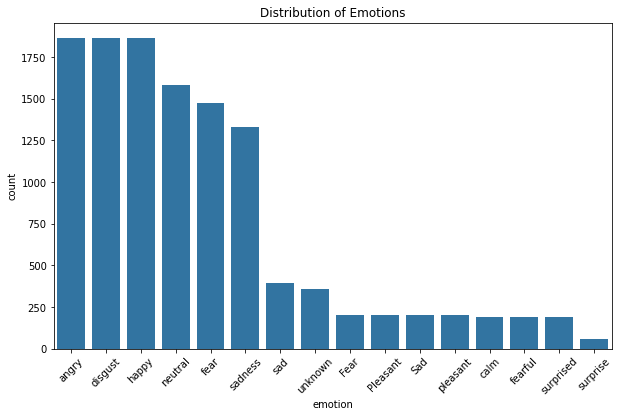

In [14]:
# distribution of emotions
plt.figure(figsize=(10, 6))
sns.countplot(data=clean_data, x='emotion', order=clean_data['emotion'].value_counts().index)
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

# this chart shows some a significant imbalance in the dataset. lets do some resampling
# Lets try using the SMOTE technique (Synthetic Minority Over-sampling):

In [15]:
# Convert all emotion labels to lowercase to standardize
clean_data['emotion'] = clean_data['emotion'].str.lower()

# Map similar emotions to a single label
clean_data['emotion'] = clean_data['emotion'].replace({
    'surprised': 'surprise',
    'sadness': 'sad',
    'fearful': 'fear',
    'pleasant': 'happy',
    'calm': 'neutral',
    'surprise': 'neutral'
})

clean_data = clean_data.loc[clean_data['emotion'] != 'unknown']

# Check the unique values after standardization
unique_emotions = clean_data['emotion'].unique()
print("Unique emotions after mapping:", unique_emotions)

Unique emotions after mapping: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


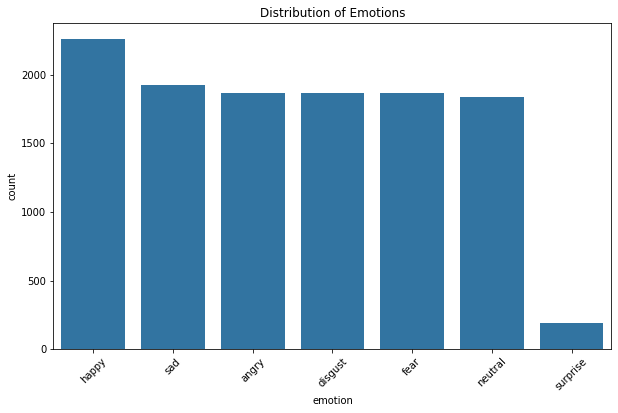

,mfccs,spectral_centroid,chroma,zero_crossing_rate,path,filename,emotion
0,"[[-589.8760375976562, 47.880348205566406, 34.0...","[1319.6803872191083, 1173.8460792183148, 1190....","[[0.8681901097297668, 0.8324087858200073, 0.80...","[0.04833984375, 0.05712890625, 0.0673828125, 0...",dataset\Crema,1001_DFA_ANG_XX.wav,angry
1,"[[-494.1741027832031, 107.23338317871094, 34.1...","[1180.9858712193702, 1197.4237182790616, 1115....","[[0.5067101120948792, 0.8211945295333862, 0.64...","[0.01953125, 0.03125, 0.0380859375, 0.04052734...",dataset\Crema,1001_DFA_DIS_XX.wav,disgust
2,"[[-466.0972900390625, 106.16978454589844, 33.1...","[1291.4565400296353, 1240.9293681854763, 1297....","[[0.6143918037414551, 1.0, 0.5763747096061707,...","[0.0166015625, 0.03173828125, 0.04150390625, 0...",dataset\Crema,1001_DFA_FEA_XX.wav,fear
3,"[[-465.77593994140625, 85.6107406616211, 47.10...","[1535.1231379899987, 1312.125645938991, 1364.0...","[[0.23183658719062805, 0.2823021113872528, 0.4...","[0.02490234375, 0.0341796875, 0.0498046875, 0....",dataset\Crema,1001_DFA_HAP_XX.wav,happy
4,"[[-484.9637145996094, 112.21417236328125, 39.0...","[1125.1491697427234, 1094.2834160756547, 1121....","[[0.10831509530544281, 0.04355860874056816, 0....","[0.015625, 0.02490234375, 0.0341796875, 0.0371...",dataset\Crema,1001_DFA_NEU_XX.wav,neutral


In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(data=clean_data, x='emotion', order=clean_data['emotion'].value_counts().index)
plt.title('Distribution of Emotions')
plt.xticks(rotation=45)
plt.show()

clean_data.head()

## Previous Model Iterations / Evaluations


#### Evaluation v1:

Classification Report (grid search)

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.46    | 2433    |
| macro avg     | 0.43      | 0.43   | 0.43     | 2433    |
| weighted avg  | 0.46      | 0.46   | 0.45     | 2433    |

#### Evaluation v2:

Classification Report (grid search with SMOTE):

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.71    | 5962    |
| macro avg     | 0.70      | 0.71   | 0.70     | 5962    |
| weighted avg  | 0.70      | 0.71   | 0.71     | 5962    |

#### Evaluation v3:

Classification Report (decision tree w/ augmentation and 1500 samples per category):

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.58    | 2700    |
| macro avg     | 0.57      | 0.58   | 0.57     | 2700    |
| weighted avg  | 0.57      | 0.58   | 0.57     | 2700    |

Accuracy of 59%; certainly an imporovement! But nothing substantial. 

Despite evening the distribution, we are still not seeing the model perform well. This is likely because 7k records
is probably not enough to get good predictive capacity over our 7 categories. 

the f1-scores that indicate weaknesses in our model is: disgust, fear, happy. this tells me that maybe we shouldn't have deleted 

Let's engineer the categories into pos/neg binary classification and see if that improves our results.

#### Evaluation v4:

Classification Report (decision tree w/ even distribution, no deleting records):

|               | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| accuracy      |           |        |          | 0.56    | 3135    |
| macro avg     | 0.57      | 0.59   | 0.57     | 3135    |
| weighted avg  | 0.55      | 0.56   | 0.54     | 3135    |

Accuracy of 55.34%: While this may seem like a drop, it's important to note that the dataset has been augmented, which can affect the accuracy score. 

F1-scores: 
- the f1-scores for underrepresented classes like 'disgust', 'fear', and 'happy' slightly improved compared to previous version.
- the f1-score for 'neutral' decreased slightly (0.02), which could be due to the additional augmented samples
- the f1-score for the other classes either remained or improved marginally

Precision / Recall:
- the recall for underrepresented classes has generally improved
- however, the precision (ability to not label negative instances as positive) has decreased, which could be due to the introduction of noise in the augmented data.

#### Evaluation v5

Classification Report (logistic regression for **binary classification**):  

| | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| Negative | 0.65 | 0.74 | 0.69 | 1536 |
| Positive | 0.36 | 0.27 | 0.31 | 825 |
| accuracy | | | | 0.57 | 2361 |
| macro avg | 0.51 | 0.51 | 0.50 | 2361 |
| weighted avg | 0.55 | 0.57 | 0.56 | 2361 |

As suspected, the 'positive' data suffered due to imbalanced classes. 

Let's augment some of the audio for the 'positive' class, and bring it closer to the negative class balance.

#### Evaluation v6
Classification Report (logistic regression for **binary classification with augmented data**): 

| | precision | recall | f1-score | support |
|---------------|-----------|--------|----------|---------|
| Negative | 0.65 | 0.74 | 0.69 | 1536 |
| Positive | 0.36 | 0.27 | 0.31 | 825 |
| accuracy | | | | 0.57 | 2361 |
| macro avg | 0.51 | 0.51 | 0.50 | 2361 |
| weighted avg | 0.55 | 0.57 | 0.56 | 2361 |

Having the same values as v5, I believe where we split the data caused data leakage.

#### Evaluation v7

Classification Report (neural network for multiclassification):

| Emotion   | Precision | Recall | F1-Score | Support |
|-----------|-----------|--------|----------|---------|
| angry     | 0.66      | 0.60   | 0.63     | 405     |
| calm      | 0.74      | 0.86   | 0.79     | 291     |
| disgust   | 0.52      | 0.30   | 0.38     | 383     |
| fear      | 0.71      | 0.22   | 0.34     | 388     |
| happy     | 0.39      | 0.40   | 0.39     | 364     |
| neutral   | 0.42      | 0.57   | 0.49     | 367     |
| pleasant  | 0.75      | 0.94   | 0.84     | 283     |
| sad       | 0.49      | 0.59   | 0.53     | 374     |
| surprise  | 0.58      | 0.89   | 0.70     | 280     |
| **accuracy** |           |        | 0.57     | 3135    |
| **macro avg** | 0.59      | 0.60   | 0.57     | 3135    |
| **weighted avg** | 0.58      | 0.57   | 0.55     | 3135    |

Not much better. Tried better feature extraction for only 2% increase (59%)


#### Evaluation v8:

Classification Report (Convolutional Neural Network with better features):

| Emotion    | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| Angry      | 0.72      | 0.70   | 0.71     | 405     |
| Calm       | 0.77      | 0.97   | 0.86     | 291     |
| Disgust    | 0.45      | 0.31   | 0.37     | 383     |
| Fear       | 0.63      | 0.27   | 0.38     | 388     |
| Happy      | 0.46      | 0.43   | 0.44     | 364     |
| Neutral    | 0.49      | 0.63   | 0.55     | 367     |
| Pleasant   | 0.88      | 0.94   | 0.91     | 283     |
| Sad        | 0.51      | 0.63   | 0.57     | 374     |
| Surprise   | 0.70      | 0.94   | 0.80     | 280     |
| **Accuracy** |           |        | **0.62** | 3135    |
| **Macro Avg** | 0.62      | 0.65   | 0.62     | 3135    |
| **Weighted Avg** | 0.61      | 0.62   | 0.60     | 3135    |

Seeing some progress! This makes sense, since CNN's are better for audio data. Lets try a more advanced CNN Architecture, this time using time series data - rather than pulling generic features to analyze. 

### Just in Case

As you can see, in some of our previous models, we used augmented audio. Though we did not use this function for the final models, I am keeping it in my notebook - just in case!

In [17]:
# audio augmentation to help with uneven data
def augment_audio(data, sr):
    # Time Stretching
    try:
        stretched_data = librosa.effects.time_stretch(data, rate=1.1)
    except Exception as e:
        stretched_data = data
    
    # Shifting 
    shift = np.random.randint(sr)
    shifted_data = np.roll(data, shift)
    
    # Volume adjustment
    amplitude_scale = np.random.uniform(low=0.8, high=1.2)
    adjusted_volume_data = data * amplitude_scale
    
    # Randomly choose one of the augmentation methods to apply
    augmentation_methods = [stretched_data, shifted_data, adjusted_volume_data]
    
    # Check for invalid values in augmentation methods
    valid_methods = [method for method in augmentation_methods if len(method) > 0 and not np.isnan(method).any() and not np.isinf(method).any()]
    
    if valid_methods:
        augmented_data = random.choice(valid_methods)
    else:
        augmented_data = data
    
    return augmented_data

## Multiclass Classification Model:

We will first attempt to create a classification model with 6 emotion classes:
> angry, happy, sad, neutral, disgust, fear

Classification Report:

| Class      | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| **angry**      | 0.69      | 0.72   | 0.71     | 362     |
| **disgust**    | 0.61      | 0.48   | 0.54     | 385     |
| **fear**       | 0.68      | 0.41   | 0.51     | 381     |
| **happy**      | 0.55      | 0.67   | 0.61     | 448     |
| **neutral**    | 0.58      | 0.62   | 0.60     | 340     |
| **sad**        | 0.57      | 0.71   | 0.63     | 408     |
| **surprise**   | 0.61      | 0.46   | 0.52     | 37      |
| **Accuracy**   |           |        | 0.60     | 2361    |
| **Macro Avg**  | 0.61      | 0.58   | 0.59     | 2361    |
| **Weighted Avg** | 0.61    | 0.60   | 0.60     | 2361    |

This model was successfully able to differentiate these emotions with 60% accuracy (much better than random guessing - which would be ~17%). 

Though, this score isn't incredibly impressive, and the difference between a customer being angry or disgusted wouldn't make a huge difference to the CS agent. Instead, we will create a binary-classification problem.


### Encode Labels and Split Data

In [18]:
# Make a copy of the clean_data DataFrame
data = clean_data.copy()

# Ensure the LabelEncoder is fit on all unique emotion labels
le = LabelEncoder()
le.fit(data['emotion']) 

# Encode the emotions for classification
data['emotion_encoded'] = le.transform(data['emotion'])  # Store encoded labels in a new column

# Create a dictionary to map encoded integers back to the original emotion strings
encoded_dict = dict(zip(le.classes_, le.transform(le.classes_)))
print("Emotion to Encoded Integer Mapping: ", encoded_dict)

# One-hot encode the labels for neural network output
one_hot_encoder = OneHotEncoder(sparse_output=False)  # Ensure sparse_output=False to get a dense array
y = one_hot_encoder.fit_transform(data['emotion_encoded'].values.reshape(-1, 1))

# Store the labels separately for resampling (if needed)
y_labels = data['emotion_encoded']

# Drop columns that are not features for model training
X = data.drop(['emotion', 'emotion_encoded', 'path', 'filename'], axis=1, errors='ignore')

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
    X, y, y_labels, test_size=0.2, random_state=42)

# Check the shape of the training and test data to confirm everything is correct
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Emotion to Encoded Integer Mapping:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
X_train shape: (9441, 4), y_train shape: (9441, 7)
X_test shape: (2361, 4), y_test shape: (2361, 7)


### Data Cleaning

In [19]:
# Define the columns that contain the time-series data
columns_to_aggregate = ['mfccs', 'chroma', 'zero_crossing_rate', 'spectral_centroid']

# Define a function to pad the time-series data to the same length
def pad_time_series(series, target_length):
    """Pads the time-series to the specified target length with zeros."""
    return np.pad(series, (0, max(0, target_length - len(series))), 'constant')

# Find the maximum length of time-series across all columns (timesteps)
def find_max_timesteps(df, columns):
    return max(df[columns].applymap(lambda x: len(x)).max())

# Pad all time-series columns to have the same number of timesteps (max length)
def pad_time_series_df(df, columns, target_length):
    for col in columns:
        df[col] = df[col].apply(lambda x: pad_time_series(x, target_length))
    return df

# Find the maximum number of timesteps across all the time-series columns
max_timesteps = find_max_timesteps(X_train, columns_to_aggregate)

# Pad the time-series data in both training and test datasets
X_train_padded = pad_time_series_df(X_train, columns_to_aggregate, max_timesteps)
X_test_padded = pad_time_series_df(X_test, columns_to_aggregate, max_timesteps)

In [20]:
def stack_time_series(df, columns):
    # Convert each time-series column to a 3D array (samples, timesteps, 1 feature)
    stacked_arrays = []
    for col in columns:
        # Convert each column to a 2D array: (samples, timesteps)
        col_array = np.array(df[col].tolist())
        
        # Check if the array is 2D (i.e., has only (samples, timesteps)), then add a feature dimension
        if len(col_array.shape) == 2:
            # Add a new axis to make it (samples, timesteps, 1)
            col_array = np.expand_dims(col_array, axis=-1)
        
        # Append the 3D array (samples, timesteps, features)
        stacked_arrays.append(col_array)
    
    # Stack along the feature axis to create a 3D array: (samples, timesteps, features)
    return np.concatenate(stacked_arrays, axis=-1)

# Convert the padded time-series columns for training and test data
X_train_3d = stack_time_series(X_train_padded, columns_to_aggregate)
X_test_3d = stack_time_series(X_test_padded, columns_to_aggregate)

# Check the shape of the resulting 3D arrays
print("Shape of X_train_3d:", X_train_3d.shape)  # Expected shape: (samples, timesteps, features)
print("Shape of X_test_3d:", X_test_3d.shape)

Shape of X_train_3d: (9441, 862, 34)
Shape of X_test_3d: (2361, 862, 34)


### Define CNN Model

In [21]:
# Get timesteps and features from the new 3D array
timesteps = X_train_3d.shape[1]
features = X_train_3d.shape[2]
print(f"Timesteps: {timesteps}, Features: {features}")

Timesteps: 862, Features: 34


In [22]:
# Define the CNN model
model = Sequential()

# First convolutional layer (input_shape = (timesteps, features))
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(timesteps, features)))
model.add(MaxPooling1D(pool_size=2))  # Max pooling to reduce dimensionality

# Second convolutional layer
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Third convolutional layer
model.add(Conv1D(128, kernel_size=1, activation='relu'))

# Flatten the output to feed into Dense layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer (number of emotions, use softmax for multiclass classification)
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 860, 32)           3296      
                                                                 
 max_pooling1d (MaxPooling1  (None, 430, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 428, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 214, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 214, 128)          8320      
                                                                 
 flatten (Flatten)           (None, 27392)             0

In [23]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model with EarlyStopping
history = model.fit(
    X_train_3d, 
    y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test_3d, y_test), 
    callbacks=[early_stopping] 
)

Epoch 1/20
296/296 [==============================] - 26s 83ms/step - loss: 3.9676 - accuracy: 0.2920 - val_loss: 1.4686 - val_accuracy: 0.4155
Epoch 2/20
296/296 [==============================] - 24s 82ms/step - loss: 1.4682 - accuracy: 0.4093 - val_loss: 1.4002 - val_accuracy: 0.4337
Epoch 3/20
296/296 [==============================] - 27s 90ms/step - loss: 1.3590 - accuracy: 0.4430 - val_loss: 1.2851 - val_accuracy: 0.4977
Epoch 4/20
296/296 [==============================] - 25s 85ms/step - loss: 1.2855 - accuracy: 0.4815 - val_loss: 1.1777 - val_accuracy: 0.5303
Epoch 5/20
296/296 [==============================] - 24s 80ms/step - loss: 1.2421 - accuracy: 0.4967 - val_loss: 1.1718 - val_accuracy: 0.5210
Epoch 6/20
296/296 [==============================] - 23s 79ms/step - loss: 1.1940 - accuracy: 0.5205 - val_loss: 1.1206 - val_accuracy: 0.5523
Epoch 7/20
296/296 [==============================] - 24s 80ms/step - loss: 1.1708 - accuracy: 0.5331 - val_loss: 1.1420 - val_accuracy:

### Evaluation

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_3d, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict on the test set
y_pred_proba = model.predict(X_test_3d)  # Predicted probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Get the predicted class labels
y_test_classes = np.argmax(y_test, axis=1)  # Get the true class labels

# Print evaluation metrics using the zero_division parameter to handle undefined metrics
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred, target_names=le.classes_, zero_division=0))

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_classes, y_pred))

Test Loss: 1.0211, Test Accuracy: 0.6023
74/74 [==============================] - 1s 9ms/step

Classification Report:
               precision    recall  f1-score   support

       angry       0.69      0.72      0.71       362
     disgust       0.61      0.48      0.54       385
        fear       0.68      0.41      0.51       381
       happy       0.55      0.67      0.61       448
     neutral       0.58      0.62      0.60       340
         sad       0.57      0.71      0.63       408
    surprise       0.61      0.46      0.52        37

    accuracy                           0.60      2361
   macro avg       0.61      0.58      0.59      2361
weighted avg       0.61      0.60      0.60      2361

Confusion Matrix:
 [[262  23   5  56  10   5   1]
 [ 32 185  16  50  33  68   1]
 [ 28  18 157  76  27  72   3]
 [ 46  19  34 302  28  14   5]
 [  3  25   5  40 211  56   0]
 [  5  32  15  19  48 288   1]
 [  3   3   0   6   6   2  17]]


## Binary Classification

Our final binary classification model for detecting emotion in voice meets our objective of an average of 80% accuracy overall. Our two classes were:

> 0: **Negative** or UPSET



> 1: **Positive** or NOT UPSET

With the f1-score of 86% for detecting negative emotions, and 68% for detecting positive / neutral emotions: our model is definitely capable of flagging customers when they are upset or not on the phone! This discrepency is likely due to the imbalance of positive/negative values in our dataset. I chose not to augment positive samples for this model, as it seemed to add noise and confusion to the model. 

*Note: model performance fluctuates on each run.*

Classification Report:

| Class      | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| **Negative** | 0.80      | 0.94   | 0.86     | 1585    |
| **Positive** | 0.81      | 0.51   | 0.63     | 776     |
| **Accuracy** |           |        | 0.80     | 2361    |
| **Macro Avg** | 0.80      | 0.73   | 0.75     | 2361    |
| **Weighted Avg** | 0.80      | 0.80   | 0.79     | 2361    |


### Data Preparation

In [25]:
# Define positive and negative emotions
positive_emotions = ['happy', 'neutral', 'surprise']
negative_emotions = ['sad', 'angry', 'disgust', 'fear']

# Decode integer labels back to original string labels
y_train_labels_decoded = le.inverse_transform(y_train_labels)  # Decode integer labels to string labels
y_test_labels_decoded = le.inverse_transform(y_test_labels)    # Decode integer labels to string labels

# Relabel the dataset for binary classification
def relabel_emotions(y, emotion_labels, positive_emotions, negative_emotions):
    """Convert multiclass emotion labels to binary classification (positive/negative)."""
    binary_labels = []
    for label in emotion_labels:
        if label in positive_emotions:
            binary_labels.append(1)  # 1 for positive emotions
        elif label in negative_emotions:
            binary_labels.append(0)  # 0 for negative emotions
        else:
            raise ValueError(f"Unknown emotion label: {label}")
    return np.array(binary_labels)

# Use the decoded string labels for relabeling
y_train_binary = relabel_emotions(y_train_labels_decoded, y_train_labels_decoded, positive_emotions, negative_emotions)
y_test_binary = relabel_emotions(y_test_labels_decoded, y_test_labels_decoded, positive_emotions, negative_emotions)

# Convert the binary labels into a format suitable for model training
y_train_binary_encoded = np.eye(2)[y_train_binary]  # Convert 0/1 labels to one-hot encoding
y_test_binary_encoded = np.eye(2)[y_test_binary]    # Convert 0/1 labels to one-hot encoding

# Check the shape of the binary labels
print(f"Shape of y_train_binary_encoded: {y_train_binary_encoded.shape}")
print(f"Shape of y_test_binary_encoded: {y_test_binary_encoded.shape}")

Shape of y_train_binary_encoded: (9441, 2)
Shape of y_test_binary_encoded: (2361, 2)


### CNN Model for Binary Classification

In [26]:
# Define the CNN model for binary classification
model = Sequential()

# First convolutional layer (input_shape = (timesteps, features))
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
model.add(MaxPooling1D(pool_size=2))  # Max pooling to reduce dimensionality

# Second convolutional layer
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Third convolutional layer
model.add(Conv1D(128, kernel_size=1, activation='relu'))

# Flatten the output to feed into Dense layers
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer for binary classification (2 classes: positive/negative)
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 860, 32)           3296      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 430, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 428, 64)           6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 214, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 214, 128)          8320      
                                                                 
 flatten_1 (Flatten)         (None, 27392)            

### Define and Train the CNN Model

In [27]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_3d, 
    y_train_binary_encoded, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test_3d, y_test_binary_encoded),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_3d, y_test_binary_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/20
296/296 [==============================] - 25s 81ms/step - loss: 2.0630 - accuracy: 0.6382 - val_loss: 0.5739 - val_accuracy: 0.7082
Epoch 2/20
296/296 [==============================] - 24s 80ms/step - loss: 0.5937 - accuracy: 0.6816 - val_loss: 0.5666 - val_accuracy: 0.6963
Epoch 3/20
296/296 [==============================] - 24s 80ms/step - loss: 0.5859 - accuracy: 0.6858 - val_loss: 0.5558 - val_accuracy: 0.7128
Epoch 4/20
296/296 [==============================] - 24s 81ms/step - loss: 0.5763 - accuracy: 0.6958 - val_loss: 0.5339 - val_accuracy: 0.7217
Epoch 5/20
296/296 [==============================] - 24s 79ms/step - loss: 0.5600 - accuracy: 0.7035 - val_loss: 0.5789 - val_accuracy: 0.7052
Epoch 6/20
296/296 [==============================] - 24s 80ms/step - loss: 0.5472 - accuracy: 0.7104 - val_loss: 0.5177 - val_accuracy: 0.7344
Epoch 7/20
296/296 [==============================] - 24s 80ms/step - loss: 0.5219 - accuracy: 0.7251 - val_loss: 0.5075 - val_accuracy:

### Model Evaluation

In [28]:
# Predict on the test set
y_pred_proba = model.predict(X_test_3d)  # Predicted probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Get the predicted class labels (0 or 1)
y_test_classes = np.argmax(y_test_binary_encoded, axis=1)  # Get the true class labels (0 or 1)

# Print evaluation metrics
print("\nClassification Report:\n", classification_report(y_test_classes, y_pred, target_names=['Negative', 'Positive'], zero_division=0))

# Print the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test_classes, y_pred))

74/74 [==============================] - 1s 10ms/step

Classification Report:
               precision    recall  f1-score   support

    Negative       0.75      0.93      0.83      1536
    Positive       0.77      0.42      0.55       825

    accuracy                           0.75      2361
   macro avg       0.76      0.68      0.69      2361
weighted avg       0.76      0.75      0.73      2361

Confusion Matrix:
 [[1433  103]
 [ 476  349]]


---
## Evaluation of Final Model: Binary Classification

#### Justification

For this emotion detection model, **precision**, **recall**, and **f1-score** are crucial metrics, as both false-positives (incorrectly flagging calm customers) and false-negatives (missing upset customers) can impact customer satisfaction.

- **Precision**:
  - **Negative (calm)**: 80% of predicted calm customers were actually calm.
  - **Positive (upset)**: 81% of predicted upset customers were actually upset.
  
- **Recall**:
  - **Negative (calm)**: 94% of calm customers were correctly identified.
  - **Positive (upset)**: 51% of upset customers were correctly identified.
  
- **F1-Score**:
  - **Negative (calm)**: 86%
  - **Positive (upset)**: 63%

This model is effective for:
- **Operational Efficiency**: The model can alert agents when a customer is upset, allowing them to adjust their approach in real-time, improving customer experience.
- **Escalation Control**: By tracking how long a customer remains upset, the model can help escalate calls to specialized teams, ensuring that frustrated customers receive the attention they need before issues escalate further.
- **Agent Training and Feedback**: The model provides valuable performance metrics, which can be used to give specific feedback to agents on how they handle both positive and negative calls, improving overall service quality.